# Setup

In [ ]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [ ]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157,8.22,100,treino
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157,0.41,40,treino
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.87,63,treino
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157,1.16,73,treino


# Pré-processamento LSTM

As redes LTSM precisam dos dados em 3 dimensões (batch, timesteps, variables), porém não existe uma quantidade fixa de dias de negócios para cada opção, com isso para fixar um valor de time steps, primeiramente foi analisada qual opção com mais dias de negócio e foram criados dias em branco com valores 0 para ajustar as demais opçãos a essa quantidade de dias de negócio, esses valores não prejudicam o treinamento, porque no cálculo da função de perda, são desconsiderados esses valores em branco.

In [ ]:
#@title Padding time steps

# Reset Index
data = data.reset_index()

# Criar dataframe de referência
reference = data.groupby(['data_vencimento', 'codigo', 'mercado', 'base'], as_index=False).agg({'T': 'count'})

# Dataframe para anexar os dados de cada loop
data_padded = pd.DataFrame()

# Tamanho da maior sequência
timestep_length = reference['T'].max() #341

# Loop sobre o dataframe de referência
for index, row in reference.iterrows():

    # Filtrar os dados para uma opção
    subset = data[(data['data_vencimento'] == row['data_vencimento']) & (data['codigo'] == row['codigo'])]

    # Calcular o tamanho dos que serão anexadoss
    size = timestep_length - subset.shape[0]

    # Criar o dataframe dummy com os dados nulos
    subset = pd.DataFrame({'index': pd.date_range(start='1/1/2010', periods=size),
                'codigo': [row['codigo']] * size,
                'mercado': [row['mercado']] * size,
                'preco_opcao': [0.0] * size,
                'preco_exercicio': [0.0] * size,
                'data_vencimento': [row['data_vencimento']] * size,
                'T': [0.0] * size,
                'preco_ativo': [0.0] * size,
                'volatilidade': [0.0] * size,
                'taxa_juros': [0.0] * size,
                'black_scholes': [0.0] * size,
                'delta_black_scholes': [0] * size,
                'base': [row['base']] * size
    }).append(subset)

    # Anexar o subset dos dados no dataframee
    data_padded = data_padded.append(subset)

# Ordenar valores
data_padded = data_padded.sort_values(by=['data_vencimento', 'codigo', 'index'])

# Adicionar o indice
data_padded.index = data_padded['index']
data_padded = data_padded.drop(['index'], axis=1)

In [ ]:
data_padded = pd.read_csv('/content/drive/My Drive/Mestrado/data/dados_padded_max_treino_teste.csv.gz', compression='gzip')
timestep_length = 341

# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- As variavéis númericas foram normalizadas antes da entrada na rede
- A variável categórica sofreu one hot encoding

A transformação dos dados é feita no mesmo momento que o modelo é treinado (evitando o problema de [training-serving_skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)), isso é feito através da criacão de um modelo vai somente processar os dados de entrada e variável alvo. 

In [ ]:
#@title Definir subset para o modelo
cols = ['preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros', 'mercado', 'preco_opcao']
features = data[cols].copy()
labels = features.pop('preco_opcao')

In [ ]:
#@title Definir variáveis de entrada
inputs = {}

for name, column in features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [ ]:
#@title Definir variáveis númericas e normalizar
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype==tf.float32}

x = tf.keras.layers.Concatenate(name='concatenate_numeric')(list(numeric_inputs.values()))
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

In [ ]:
#@title Definir categóricas e aplicar one hot encoding
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['OPÇÕES DE VENDA', 'OPÇÕES DE COMPRA'])
    one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

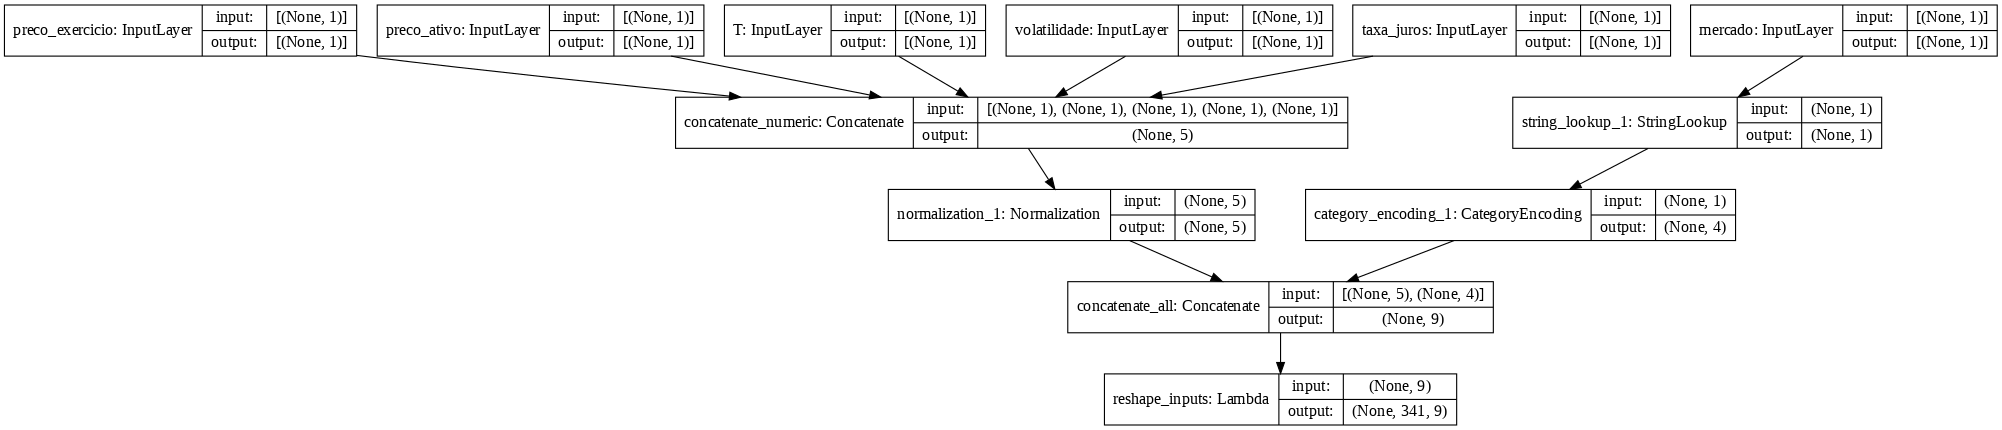

In [ ]:
#@title Concatenar dados de entrada e criar modelo para processamento das variavéis
preprocessed_inputs_concat = tf.keras.layers.Concatenate(name='concatenate_all')(preprocessed_inputs)
reshape_inputs = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, timestep_length, preprocessed_inputs_concat.shape[1])), name='reshape_inputs')(preprocessed_inputs_concat)
model_preprocessing_input = tf.keras.Model(inputs, reshape_inputs)
tf.keras.utils.plot_model(model=model_preprocessing_input, rankdir="TD", dpi=80, show_shapes=True)

In [ ]:
#@title Amostra de dados de entrada processados
sample_features_dict = {name: np.array(value) for name, value in features.items()}
sample_features_dict = {name: values[:timestep_length] for name, values in sample_features_dict.items()}
model_preprocessing_input(sample_features_dict)

<tf.Tensor: shape=(1, 341, 9), dtype=float32, numpy=
array([[[-0.16609144, -1.262118  , -0.5997047 , ...,  0.        ,
          1.        ,  0.        ],
        [-1.2128178 , -1.262118  , -0.5997047 , ...,  0.        ,
          1.        ,  0.        ],
        [-1.6438228 , -1.262118  , -0.5997047 , ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [-0.7202407 , -1.3005961 , -0.2999    , ...,  0.        ,
          0.        ,  1.        ],
        [-1.0170184 , -1.3005961 ,  4.989511  , ...,  0.        ,
          0.        ,  1.        ],
        [-0.8938741 , -1.3005961 ,  4.989511  , ...,  0.        ,
          0.        ,  1.        ]]], dtype=float32)>

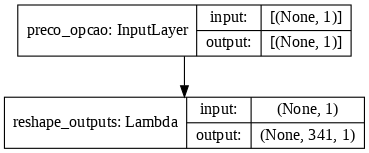

In [ ]:
#@title Definir variável alvo
outputs = tf.keras.Input(shape=(1,), name='preco_opcao', dtype=tf.float32)
reshape_outputs = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, timestep_length, outputs.shape[1])), name='reshape_outputs')(outputs)
model_preprocessing_output = tf.keras.Model(outputs, reshape_outputs)
tf.keras.utils.plot_model(model=model_preprocessing_output, rankdir="TD", dpi=80, show_shapes=True)

In [ ]:
#@title Amostra de dados da variável alvo processados
sample_features_dict = {'preco_opcao': labels.values[:timestep_length]}
model_preprocessing_output(sample_features_dict)

<tf.Tensor: shape=(1, 341, 1), dtype=float32, numpy=
array([[[8.180e+00],
        [3.600e-01],
        [2.000e-02],
        [7.900e-01],
        [1.130e+00],
        [1.580e+00],
        [2.540e+00],
        [9.400e-01],
        [1.300e-01],
        [9.000e-02],
        [3.950e+00],
        [2.800e-01],
        [1.062e+01],
        [1.500e-01],
        [1.000e-01],
        [8.000e+00],
        [7.130e+00],
        [4.980e+00],
        [6.230e+00],
        [6.100e-01],
        [5.170e+00],
        [6.500e-01],
        [5.870e+00],
        [7.300e-01],
        [9.000e-02],
        [4.000e-02],
        [2.100e+00],
        [1.000e-01],
        [6.000e-02],
        [2.990e+00],
        [1.500e-01],
        [3.900e-01],
        [1.000e-01],
        [4.000e-01],
        [3.400e-01],
        [1.000e+00],
        [2.040e+00],
        [4.300e-01],
        [4.170e+00],
        [3.200e-01],
        [2.290e+00],
        [3.000e-02],
        [2.600e-01],
        [8.500e-01],
        [2.100e+00],
  

In [ ]:
#@title tf.Data
def df_to_dataset(dataframe, base, batch_size, timesteps):

    dataframe = dataframe.copy()
    dataframe = dataframe[dataframe['base'] == base]
    cols = ['mercado', 'preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros', 'preco_opcao']
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[cols])))
    return ds.batch(batch_size*timesteps)

# Tamanho do batch
batch_size = 22

# Divisão da base de treino e teste
train_ds = df_to_dataset(data_padded, batch_size=batch_size, timesteps=timestep_length, base='treino')
test_ds = df_to_dataset(data_padded, batch_size=batch_size, timesteps=timestep_length, base='teste')

# Modelo

O modelo de rede neural profunda a seguir, foi baseado nos estudos desenvolvidos por Hirsa, Karatas, & Oskoui. No trabalho são testadas diversas arquiteturas (camadas e elementos em cada camada), bem como função de atição de cada camada e também função de otimização.

A conclusão do estudo mostra que os melhores resultados foram obtidos utilizando uma rede de 4 camadas com 120 neurônios cada uma.

In [ ]:
def custom_loss_mse(y_true, y_pred, weights):
    loss = tf.reduce_sum(tf.multiply(tf.pow((y_true - y_pred), 2), weights), axis=1)
    n = tf.reduce_sum(weights, axis=1)
    mse = tf.divide(loss, n)
    return tf.reduce_mean(mse)

def custom_metric_mae(y_true, y_pred, weights):
    loss = tf.reduce_sum(tf.multiply(tf.abs(y_true - y_pred), weights), axis=1)
    n = tf.reduce_sum(weights, axis=1)
    mae = tf.divide(loss, n)
    return tf.reduce_mean(mae)

In [ ]:
#@title Camada customizada de saída
class ReshapeEndpoint(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super(ReshapeEndpoint, self).__init__(name=name)

    def call(self, result, targets=None, sample_weight=None):

        # As métricas são calculadas somente na parte de treinamento,
        # no momento que são adicionados a variável alvo
        if targets is not None:

            # Para ajuste 
            weights = tf.where((targets > 0), tf.ones_like(targets), targets)

            # Cálcular a função de perda e adicionar a camada usando `self.add_loss()`.
            loss = custom_loss_mse(targets, result, weights)
            self.add_loss(loss)

            # Calcular a metrica na fase de treinamento
            mae = custom_metric_mae(targets, result, weights)
            self.add_metric(mae, name='mae')

        # Valor de retornor quando é utilizado o método `.predict()`
        return result

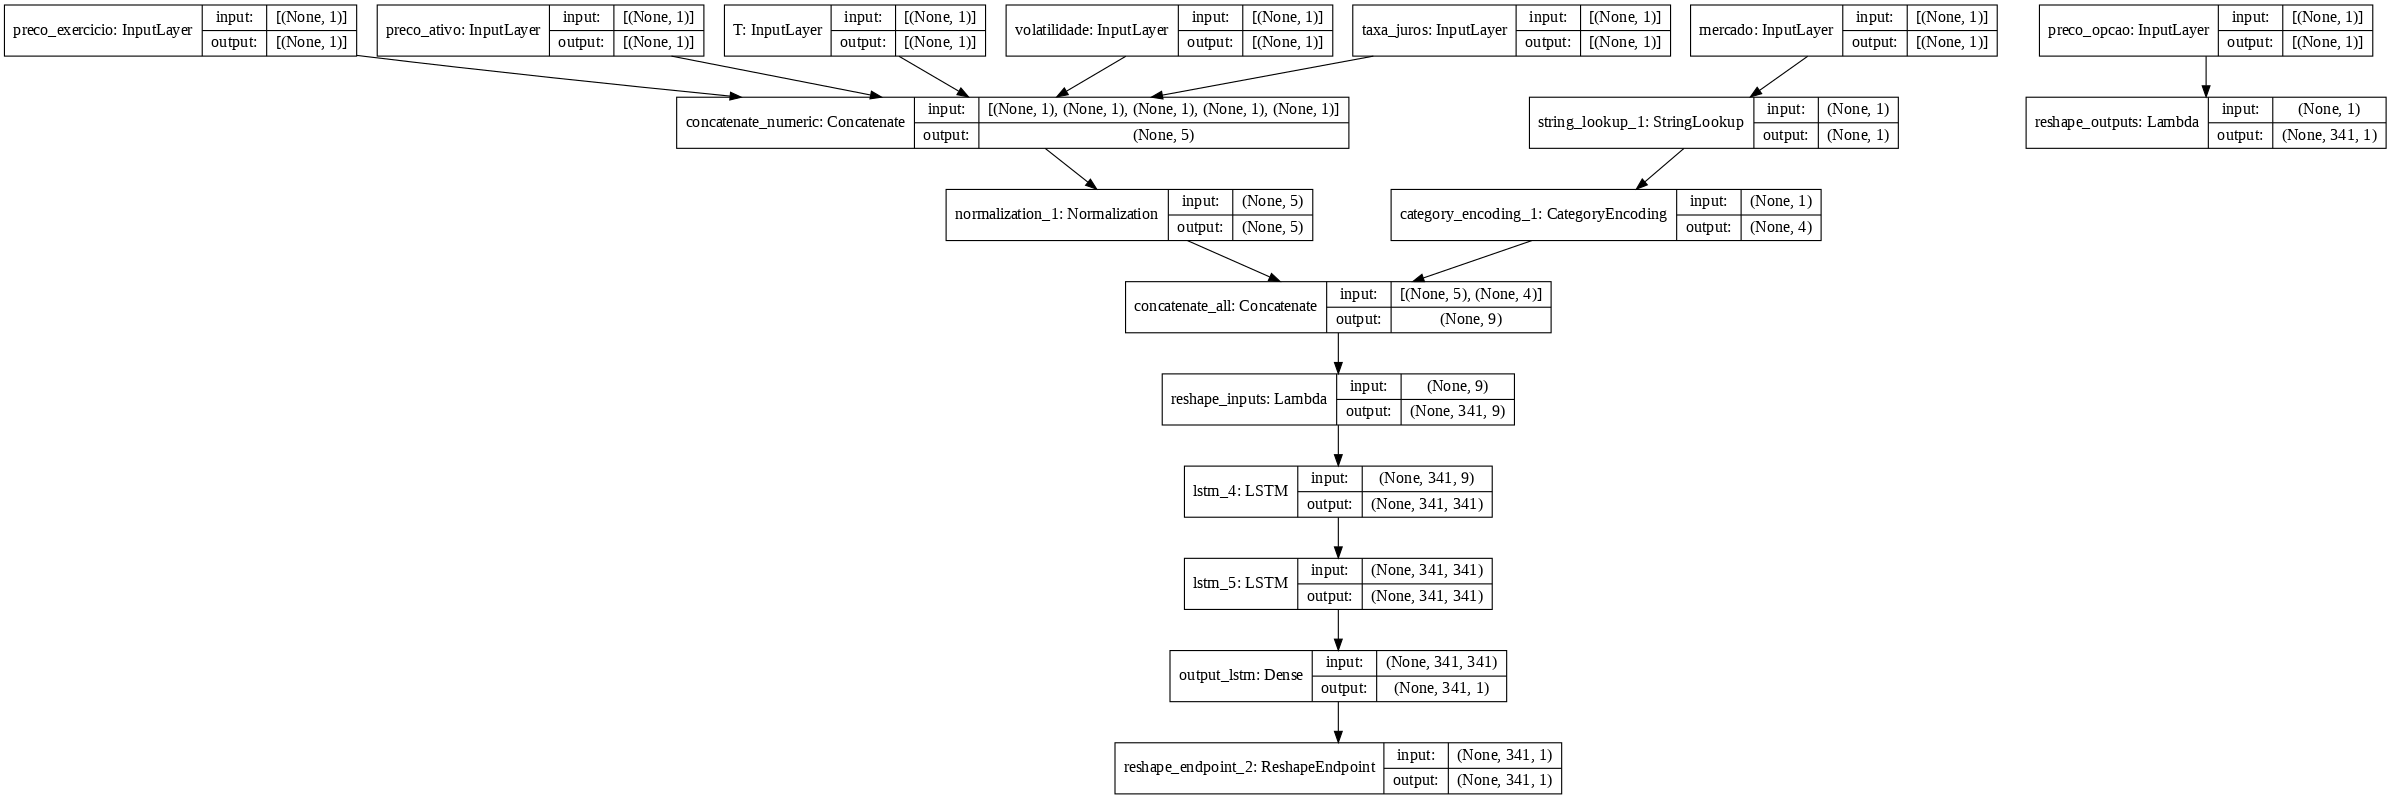

In [ ]:
#@title Criar, compilar o modelo
h = tf.keras.layers.LSTM(timestep_length, return_sequences=True)(reshape_inputs)
h = tf.keras.layers.LSTM(timestep_length, return_sequences=True)(h)
h = tf.keras.layers.Dense(120, activation='relu')(h)
h = tf.keras.layers.Dense(120, activation='relu')(h)
h = tf.keras.layers.Dense(120, activation='relu')(h)
h = tf.keras.layers.Dense(120, activation='relu')(h)
output_lstm = tf.keras.layers.Dense(1, name='output_lstm')(h)

endpoint = ReshapeEndpoint()(output_lstm, reshape_outputs)

# Create an instance of the model
model = tf.keras.Model([inputs, outputs], endpoint)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))
tf.keras.utils.plot_model(model=model, rankdir="TB", dpi=80, show_shapes=True)

In [ ]:
#@title Sumário do modelo
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
preco_exercicio (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
preco_ativo (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
T (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
volatilidade (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
element = next(iter(train_ds.take(1)))
model(element)

<tf.Tensor: shape=(22, 341, 1), dtype=float32, numpy=
array([[[0.00251615],
        [0.00476518],
        [0.00641335],
        ...,
        [0.06670557],
        [0.06356598],
        [0.06012561]],

       [[0.00251615],
        [0.00476518],
        [0.00641335],
        ...,
        [0.06120082],
        [0.05709721],
        [0.05335694]],

       [[0.00251615],
        [0.00476518],
        [0.00641335],
        ...,
        [0.05870397],
        [0.05434444],
        [0.05041584]],

       ...,

       [[0.00251615],
        [0.00476518],
        [0.00641335],
        ...,
        [0.1047213 ],
        [0.09820777],
        [0.09091683]],

       [[0.00251615],
        [0.00476518],
        [0.00641335],
        ...,
        [0.2698482 ],
        [0.27477175],
        [0.28031445]],

       [[0.00251615],
        [0.00476518],
        [0.00641335],
        ...,
        [0.1047213 ],
        [0.1047213 ],
        [0.09714865]]], dtype=float32)>

In [ ]:
#@title Callbacks
# Tensorflow checkpoint
path = '/content/drive/MyDrive/Mestrado/models/seq2seq'

# Salvar os pesos do modelo treinado
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'checkpoint',
    frequecy='epoch',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Se nas últimas 5 épocas a função de perda não diminuir em pelo menos 0.00005, a taxa de aprendizado 
# é reduzida para 20% do seu valor
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2, min_delta=0.001, patience=5, verbose=1)

# Salva os valores das métricsas em um arquivo separado
csv = tf.keras.callbacks.CSVLogger(path+"results.csv")

# Se não houver melhora na função de perda dos dados de validação em pelos menos 0.0001 nas últimas 20 épocas
# o treinamento é interrompido
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1)

In [ ]:
#@title Treino do modelo
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200, # devido a definição de callback, utilizado alto valor de épocas
    callbacks=[checkpoint, lr, csv, es]
)

Epoch 1/200
257/257 [==============================] - 27s 96ms/step - loss: 0.1035 - mae: 0.1152 - val_loss: 0.0605 - val_mae: 0.1713

Epoch 00001: val_loss improved from inf to 0.06047, saving model to /content/drive/MyDrive/Mestrado/models/lstm/max/checkpoint
Epoch 2/200
257/257 [==============================] - 24s 92ms/step - loss: 0.0367 - mae: 0.1167 - val_loss: 0.0651 - val_mae: 0.1812

Epoch 00002: val_loss did not improve from 0.06047
Epoch 3/200
257/257 [==============================] - 24s 92ms/step - loss: 0.0476 - mae: 0.1233 - val_loss: 0.0611 - val_mae: 0.1734

Epoch 00003: val_loss did not improve from 0.06047
Epoch 4/200
257/257 [==============================] - 24s 92ms/step - loss: 0.0496 - mae: 0.1250 - val_loss: 0.0598 - val_mae: 0.1707

Epoch 00004: val_loss improved from 0.06047 to 0.05982, saving model to /content/drive/MyDrive/Mestrado/models/lstm/max/checkpoint
Epoch 5/200
257/257 [==============================] - 24s 92ms/step - loss: 0.0487 - mae: 0.123

In [ ]:
#@title Métricas
metrics = pd.read_csv(path + 'results.csv')

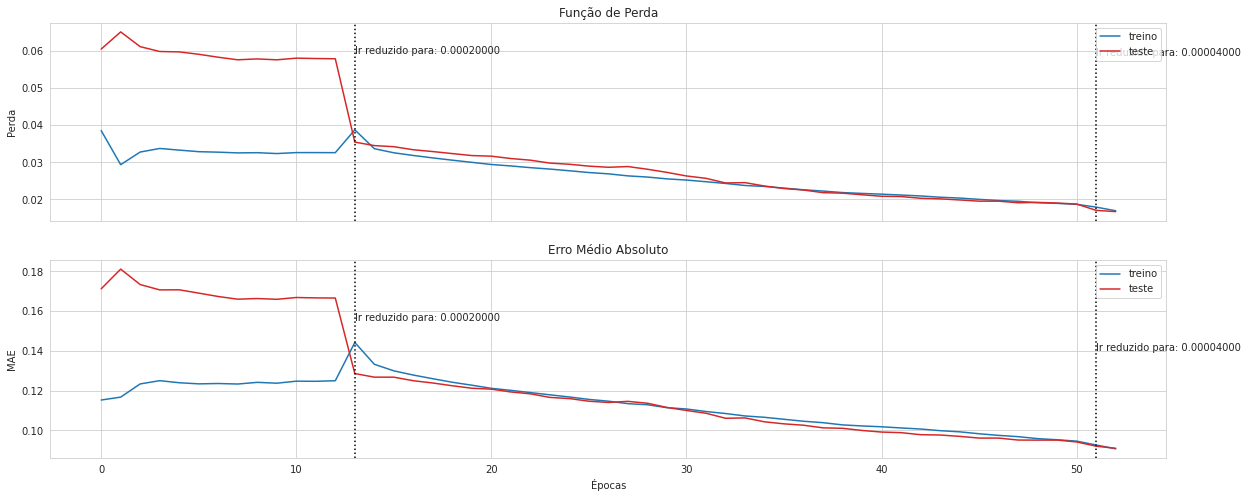

In [ ]:
#@title Plot das Métricas do Modelo

# Valor de mudança de learning rate
metrics['lr_change'] = metrics['lr'] == metrics['lr'].shift(1)

# Valores de learning para plot de gráfico
lr_change = metrics.loc[metrics['lr_change'] == False, ['epoch', 'lr']]

# Retirar a primeira linha
lr_change = lr_change[1:]

# Converter para dict
lr_change = lr_change.to_dict('records')

# Create two subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(metrics['epoch'], metrics['loss'], 'tab:blue', label='treino')
axs[0].plot(metrics['epoch'], metrics['val_loss'], 'tab:red', label='teste')
axs[0].set_title('Função de Perda')
axs[0].set(ylabel='Perda')
axs[0].legend()

axs[1].plot(metrics['epoch'], metrics['mae'], 'tab:blue', label='treino')
axs[1].plot(metrics['epoch'], metrics['val_mae'], 'tab:red', label='teste')
axs[1].set_title('Erro Médio Absoluto')
axs[1].set(ylabel='MAE')
axs[1].legend()

y_loss_pos = 0.06
y_mae_pos = 0.17

for lr in lr_change:
    axs[0].axvline(x=lr['epoch'], linestyle='dotted', color='black')
    axs[1].axvline(x=lr['epoch'], linestyle='dotted', color='black')
    y_loss_pos = y_loss_pos - 0.0007
    axs[0].text(
        x=lr['epoch'],
        y=y_loss_pos,
        s=f"lr reduzido para: {lr['lr']:.8f}",
        horizontalalignment='left'
        )
    y_mae_pos = y_mae_pos- 0.015
    axs[1].text(
        x=lr['epoch'],
        y=y_mae_pos,
        s=f"lr reduzido para: {lr['lr']:.8f}",
        horizontalalignment='left'
        )

for ax in axs.flat:
    ax.set(xlabel='Épocas')

for ax in axs.flat:
    ax.label_outer()

plt.show()